## Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from viz_preprocess import *
from viz_sequence import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

np.random.seed(1234)
plt.style.use('default')

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


## Prepare Inputs

In [2]:
input_bed = pd.read_csv('/srv/www/encode4crisprhack/gkmexplain/inputs/caprin_enhancers_dnase_intersection.hg38.input.bed', header=None, sep='\t')
input_chrom = input_bed[0].tolist()
input_start = input_bed[1].tolist()
input_end = input_bed[2].tolist()

fasta = '/srv/www/encode4crisprhack/gkmexplain/inputs/caprin_enhancers_dnase_intersection.hg38.input.fa'
hyp_file = '/srv/www/encode4crisprhack/gkmexplain/outputs/caprin_enhancers_dnase_intersection.hg38.hyp.scores'

seqs = [x.rstrip() for (i,x) in enumerate(open(fasta)) if i%2==1]
onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in seqs if ('N' not in x)]

print("Num onehot sequences:", len(onehot))

hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(hyp_file)], seqs) if 'N' not in w[1]]

imp_scores = get_impscores(hyp_scores, onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(imp_scores,
                                 onehot,
                                 hyp_scores)])) == 0

normed_imp_scores, normed_hyp_scores = normalize_scores(
    impscores=imp_scores, hyp_impscores=hyp_scores, onehot_data=onehot)

Num onehot sequences: 9


## Get Important Regions

In [3]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'score':[]}

for i,j in enumerate(seqs):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(input_chrom[i])
    seq_dict['start'].append(input_start[i])
    seq_dict['end'].append(input_end[i])
    seq_dict['score'].append(np.sum(imp_scores[i]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df = seq_df.drop_duplicates(['chr', 'start', 'end'])
seq_df.sort_values(by='score', ascending=False, inplace=True)
seq_df.head(20)

index    chr     start       end     score
0      0  chr11  33941509  33942009  1.092460
2      2  chr11  33944698  33945198  0.946630
7      7  chr11  34371392  34371892  0.219671
6      6  chr11  34371846  34372346  0.102856
8      8  chr11  34618955  34619455 -0.053236

## Visualize Top Sequences

Index:  0  Importance:  1.0924603610099999   chr11 : 33941509 - 33942009


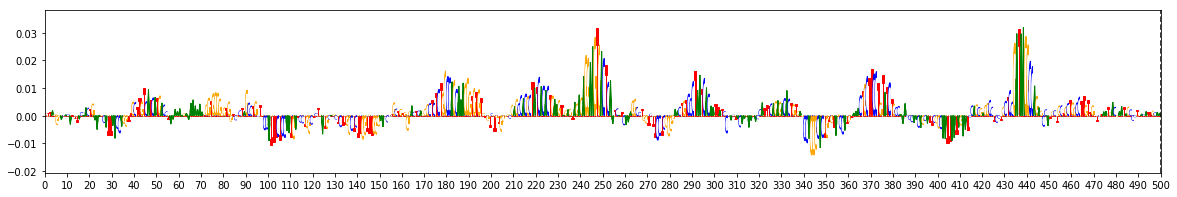

Index:  2  Importance:  0.9466298990169999   chr11 : 33944698 - 33945198


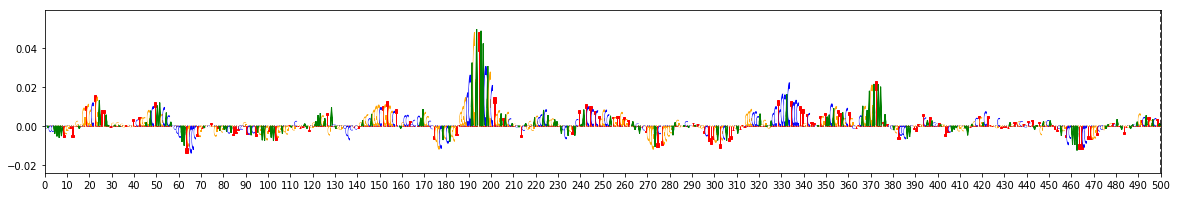

Index:  7  Importance:  0.21967083970000015   chr11 : 34371392 - 34371892


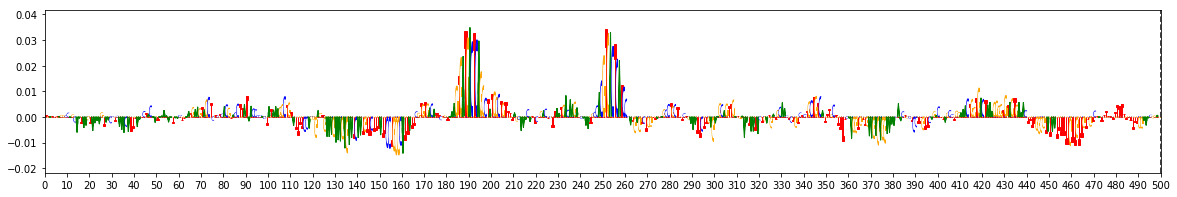

Index:  6  Importance:  0.10285585630000003   chr11 : 34371846 - 34372346


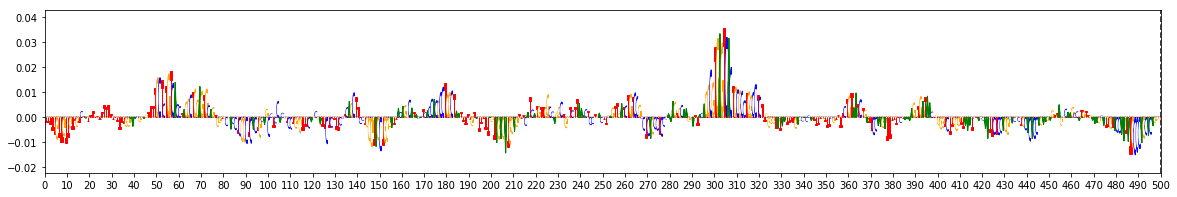

Index:  8  Importance:  -0.05323616680000001   chr11 : 34618955 - 34619455


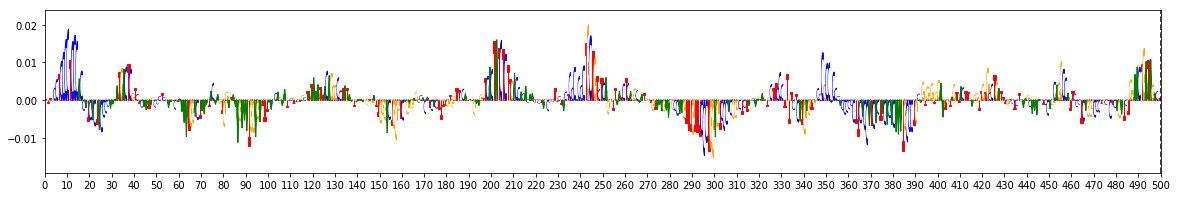

In [4]:
for idx in seq_df.iloc[:20]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'score'], ' ',
          seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    ylim = plot_weights(imp_scores[idx], subticks_frequency=10, xlim=(0,500))

Index:  0  Importance:  1.0924603610099999   chr11 : 33941509 - 33942009


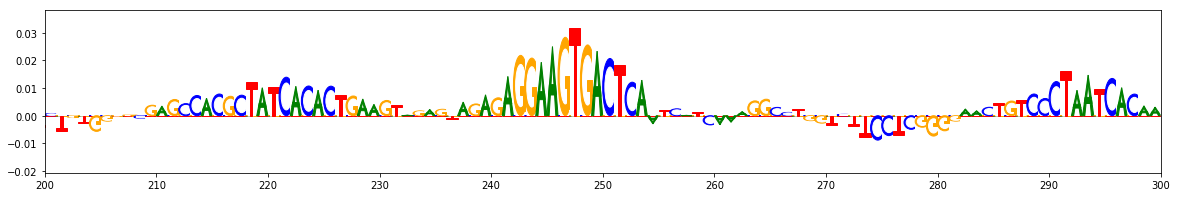

Index:  2  Importance:  0.9466298990169999   chr11 : 33944698 - 33945198


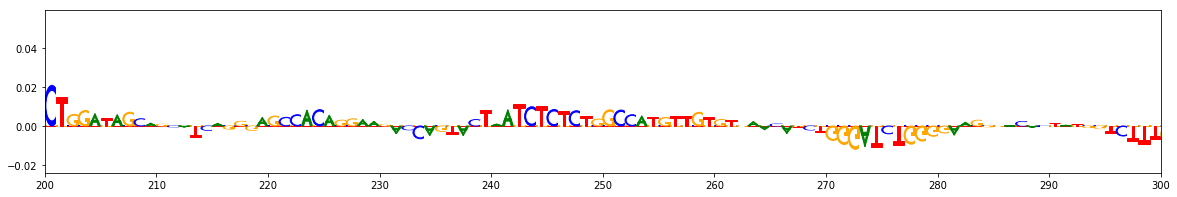

Index:  7  Importance:  0.21967083970000015   chr11 : 34371392 - 34371892


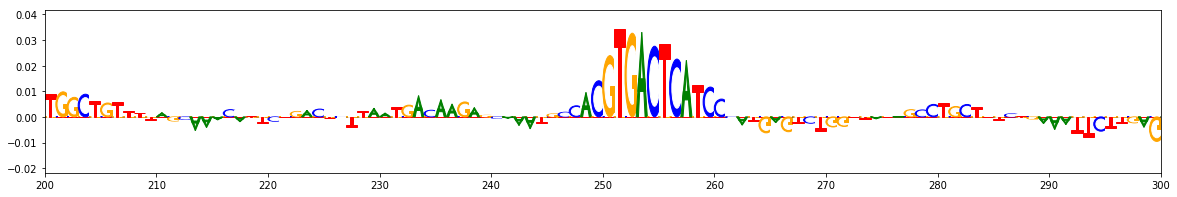

Index:  6  Importance:  0.10285585630000003   chr11 : 34371846 - 34372346


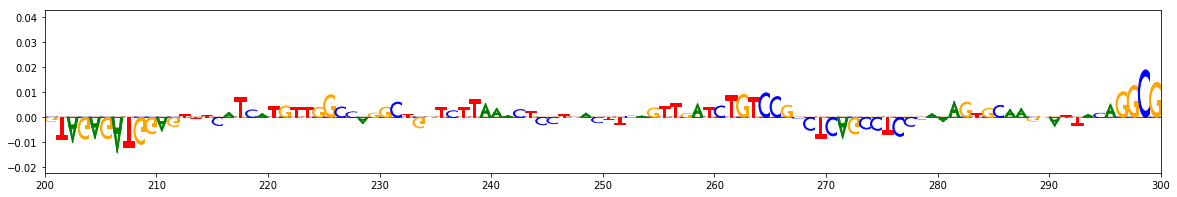

Index:  8  Importance:  -0.05323616680000001   chr11 : 34618955 - 34619455


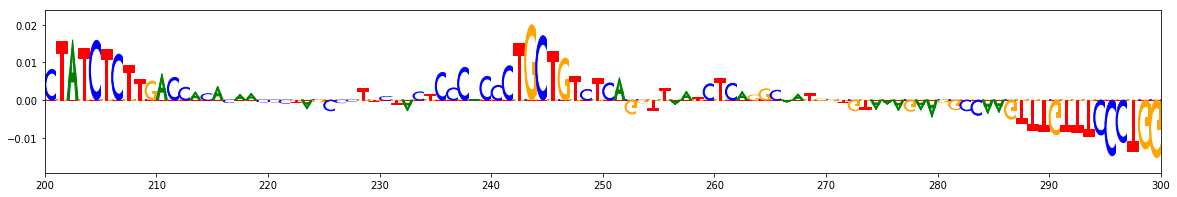

In [6]:
for idx in seq_df.iloc[:20]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'score'], ' ',
          seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    ylim = plot_weights(imp_scores[idx], subticks_frequency=10, xlim=(200,300))

Index:  0  Importance:  1.0924603610099999   chr11 : 33941509 - 33942009


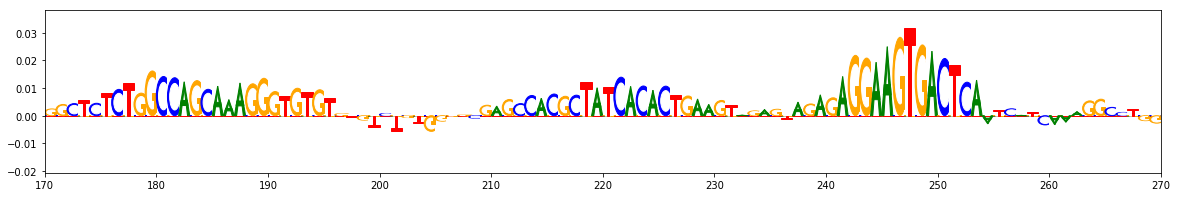

Index:  2  Importance:  0.9466298990169999   chr11 : 33944698 - 33945198


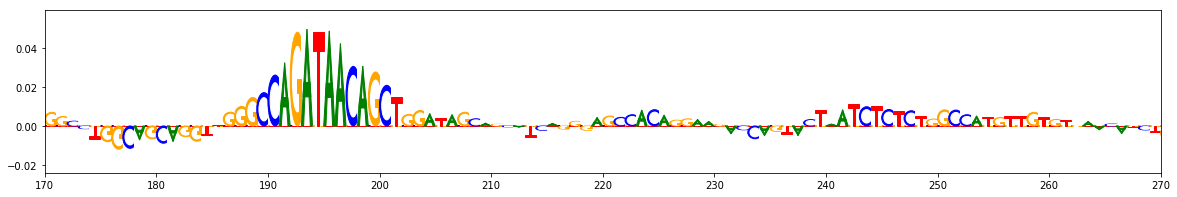

Index:  7  Importance:  0.21967083970000015   chr11 : 34371392 - 34371892


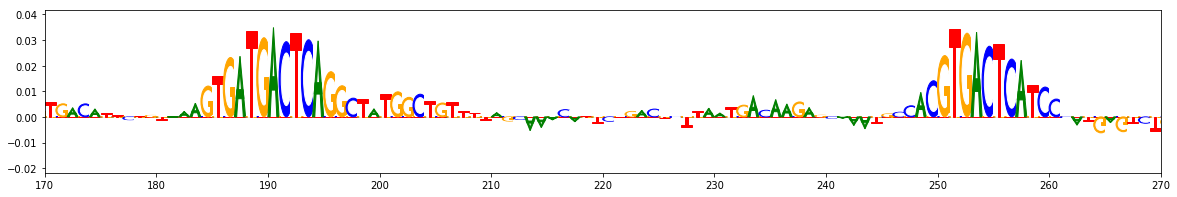

Index:  6  Importance:  0.10285585630000003   chr11 : 34371846 - 34372346


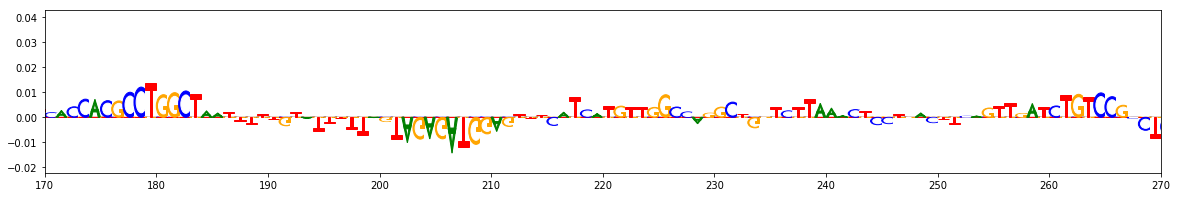

Index:  8  Importance:  -0.05323616680000001   chr11 : 34618955 - 34619455


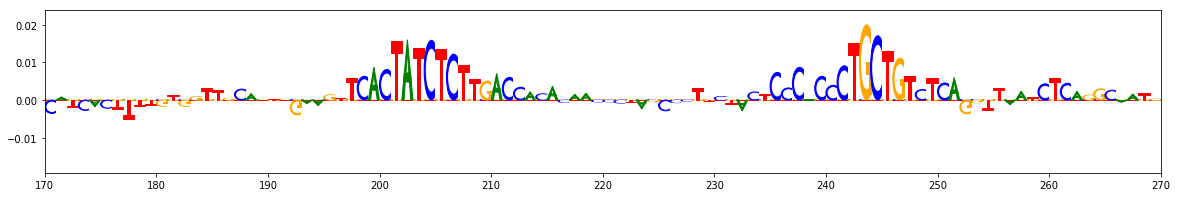

In [7]:
for idx in seq_df.iloc[:20]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'score'], ' ',
          seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    ylim = plot_weights(imp_scores[idx], subticks_frequency=10, xlim=(170,270))

## Get Dinucleotide Shuffled Sequences

In [6]:
from deeplift.dinuc_shuffle import dinuc_shuffle

np.random.seed(1234)
random.seed(1234)

num_dinuc_shuffled_seqs = 500
#Generate the dinucleotide shuffled sequences and write to a file
fasta_seqs_no_N = [x.rstrip() for (i,x) in enumerate(open("/srv/www/encode4crisprhack/gkmexplain/inputs/caprin_enhancers_dnase_intersection.hg38.input.fa"))
                   if (i%2==1 and ('N' not in x))]
open("/srv/www/encode4crisprhack/gkmexplain/inputs/dnshuff_seqs.fa", 'w').write(
 "\n".join([">"+str(i)+"\n"+dinuc_shuffle(np.random.choice(fasta_seqs_no_N))
            for i in range(num_dinuc_shuffled_seqs)]))

252889

## Normalize Importance Scores

In [9]:
def normalize_scores(impscores, hyp_impscores, onehot_data):
  #normalize the hyp scores such that, at each position, hypothetical importance
  # scores that have the same sign as the original importance score all sum
  # up to the original importance score value. The rationale is that if
  # multiple different bases at a position could produce a similar score,
  # the specific identity of each individual base is less important.
  #Empirically, hypothetical scores like these appear to work better for
  # motif discovery. Using normalized importance scores derived by taking
  # the elementwise product of the normalized hypothetical scores and
  # the one-hot encoding also seems to reduce noise.
  normed_hyp_impscores = []
  normed_impscores = []
  for i in range(len(impscores)):
      imp_score_each_pos = np.sum(impscores[i],axis=-1)
      imp_score_sign_each_pos = np.sign(imp_score_each_pos)
      hyp_scores_same_sign_mask = (np.sign(hyp_impscores[i])
                                   *imp_score_sign_each_pos[:,None] > 0)
      hyp_scores_same_sign_imp_scores_sum = np.sum(
          hyp_impscores[i]*hyp_scores_same_sign_mask,axis=-1)
      norm_ratio = imp_score_each_pos/hyp_scores_same_sign_imp_scores_sum
      norm_hyp = hyp_impscores[i]*norm_ratio[:,None]
      normed_hyp_impscores.append(norm_hyp)
      normed_impscores.append(norm_hyp*onehot_data[i])
  return normed_impscores, normed_hyp_impscores

normed_impscores, normed_hyp_impscores = normalize_scores(
  impscores=imp_scores, hyp_impscores=hyp_scores, onehot_data=onehot)

## Get DnShuff Importance Scores

In [10]:
dnshuff_impscores = [np.array( [[float(z) for z in y.split(",")]
                           for y in x.rstrip().split("\t")[2].split(";")])
                     for x in open("/srv/www/encode4crisprhack/gkmexplain/outputs/dnshuff_impscores.txt")]

## Get Seqlets

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= 0.0033233169625851173
Computing threshold
Thresholds from null dist were -0.06087994308066588  and  0.13331381462262792
Passing windows frac was 0.008754208754208754 , which is below  0.03 ; adjusting
Final raw thresholds are -0.06641096642275868  and  0.06641096642275868
Final transformed thresholds are -0.9696969696969697  and  0.9696969696969697


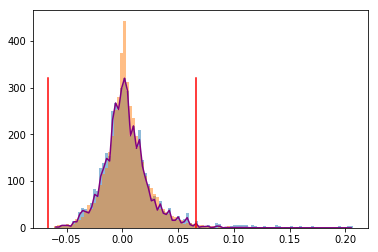

Got 20 coords
After resolving overlaps, got 20 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9696968696969698
20 identified in total
0 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  []
Idx to activities:  {}


In [21]:
from modisco.visualization import viz_sequence
import h5py

dnshuff_perposimp = [np.sum(x,axis=-1) for x in dnshuff_impscores]

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                        #Adjust sliding_window_size and flank_size according to how big you expect
                        # the core motif to be; default values are 21 and 10
                        target_seqlet_fdr=0.01,
                        sliding_window_size=6,
                        flank_size=2,
                        #Unfortunately, at the time of writing,
                        # min_seqlets_per_task is not the actual number of seqlets
                        # that will end up being produced per task, but it
                        # serves as a rough target
                        #The reason for the difference is that many candidate seqlet windows
                        # will get discarded due to overlap with other windows
                        # and it's hard to predict how many
                        #The code is still in development, so I will likely
                        # refine this option later to correspond to the actual
                        # minimum number of seqlets produced per task
                        seqlets_to_patterns_factory=modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Adjust trim_to_window_size and initial_flank_to_add
                        # according to how big you expect
                        # the core motif to be; default value is 10
                        trim_to_window_size=6,
                        initial_flank_to_add=2,
                        final_flank_to_add=5,
                        #kmer_len, num_gaps and num_mismatches are used to
                        # derive kmer embeddings for coarse-grained affinity
                        # matrix calculation. kmer_len=6, num_gaps=1
                        # and num_mismatches=0 means
                        # that kmer embeddings using 6-mers with 1 gap will be
                        # used.
                        kmer_len=6, num_gaps=1,
                        num_mismatches=0,
                        ),
                   )(
                task_names=["task0"],
                contrib_scores={'task0': normed_impscores},                
                hypothetical_contribs={'task0': normed_hyp_scores},
                one_hot=onehot)

## Visualize Seqlets

In [12]:
from modisco.aggregator import TrimToBestWindow

trimmer = TrimToBestWindow(window_size=30, track_names=["task0_contrib_scores"])

for i,pattern in enumerate(trimmer(tfmodisco_results
                                   .metacluster_idx_to_submetacluster_results[0]
                                   .seqlets_to_patterns_result.patterns)):
    print("num seqlets",len(pattern.seqlets))
    print("fwd seq PWM")
    viz_sequence.plot_weights(viz_sequence.ic_scale(
        pattern["sequence"].fwd, background=np.array([0.25,0.25,0.25,0.25])))
    print("Contrib scores")
    viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
    print("Hyp contrib scores")
    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
  
    print("rev seq PWM")
    viz_sequence.plot_weights(viz_sequence.ic_scale(
      pattern["sequence"].rev, background=np.array([0.25,0.25,0.25,0.25])))
    print("Contrib scores")
    viz_sequence.plot_weights(pattern["task0_contrib_scores"].rev)
    print("Hyp contrib scores")
    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)

KeyError: 0